# Chapter 12 - Reactive flow and the emergence of melt channels

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
from scipy.optimize import fsolve
from scipy.linalg import det
from cycler import cycler

## Linearised stability analysis

### The base state

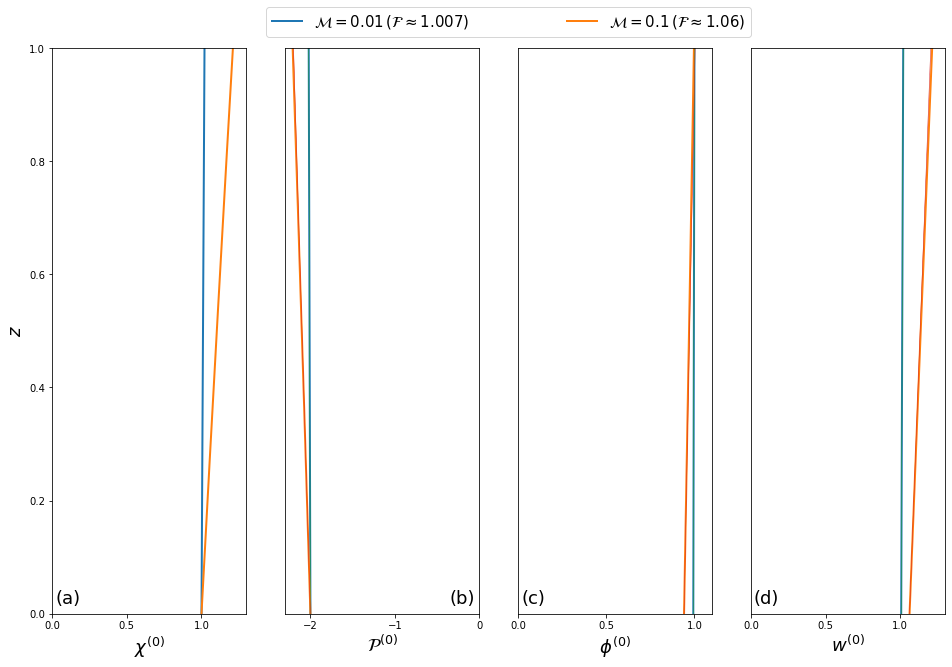

In [2]:
f, ax = plt.subplots(1, 4)
zoom = 2.0
f.set_size_inches(8.0 * zoom, 5.2 * zoom)
f.set_facecolor('w')

n = 3.0
G = 1.0
M = np.asarray([0.01, 0.1])
S = 1.0
H = 1.0
z = np.linspace(0.0, H, 1000)

F = np.power([1.0 + S*m*(1+G) for m in M], 1/n)
chi = np.asarray([(1.+G)*np.exp(m*z) - G for m in M])
cmp = -(chi + G)
phi = np.power([chij/(1.0 - S*m*cmpj) for chij, m, cmpj in zip(chi, M, cmp)], 1.0/n)
w = chi/phi
cmpl = -(1.0+G) * np.asarray([1.0 + m*z for m in M])
chil = 1.0 + np.asarray([m*(1+G)*z for m in M])
phil = np.asarray([1.0/Fj * (1.0 + m*(1.0 + G)/n*z) for Fj, m in zip(F, M)])
wl = np.asarray([Fj*(1.0 + m*(1.0+G)*(1.0-1.0/n)*z) for Fj, m in zip(F, M)])

plt.rc('axes', prop_cycle=(cycler(color=['k', 'k', 'k', 'k']) + cycler(linestyle=['-', '--', ':', '-.'])))

lines = ax[0].plot(chi.transpose(), z, linewidth=2.0)
ax[0].set_xlabel(r'$\chi^{(0)}$', fontsize=18)
ax[0].set_xlim(0.0, 1.3)
ax[0].set_xticks((0.0, 0.5, 1.0))
ax[0].set_ylabel('$z$', fontsize=18)
ax[0].set_ylim(0.0, 1.0)
ax[0].text(0.02, 0.01, '(a)', fontsize=18, verticalalignment='bottom', horizontalalignment='left')
plt.legend(handles=(lines[0], lines[1]), 
           labels=(r'$\mathcal{M}=0.01\,(\mathcal{F}\approx1.007)$', r'$\mathcal{M}=0.1\,(\mathcal{F}\approx1.06)$'),
           fontsize=15, bbox_to_anchor=(-2.5, 1.02, 2.5, .2),
           loc='lower right', ncol=2, mode="expand", borderaxespad=0.)

ax[1].plot(cmp.transpose(), z, linewidth=2.0)
ax[1].plot(cmpl.transpose(), z, linewidth=0.5)
ax[1].set_xlabel(r'$\mathcal{P}^{(0)}$', fontsize=18)
ax[1].set_xlim(-2.3, 0.0)
ax[1].set_xticks((-2.0, -1.0, 0.0))
ax[1].set_yticks(())
ax[1].set_ylim(0.0, 1.0)
ax[1].text(-0.35, 0.01, '(b)', fontsize=18, verticalalignment='bottom', horizontalalignment='left')

ax[2].plot(phi.transpose(), z, linewidth=2)
ax[2].plot(phil.transpose(), z, linewidth=0.5)
ax[2].set_yticks(())
ax[2].set_xlabel(r'$\phi^{(0)}$', fontsize=18)
ax[2].set_xlim(0.0, 1.1)
ax[2].set_xticks((0.0, 0.5, 1.0))
ax[2].set_ylim(0.0, 1.0)
ax[2].text(0.02, 0.01, '(c)', fontsize=18, verticalalignment='bottom', horizontalalignment='left')

ax[3].plot(w.transpose(), z, linewidth=2)
ax[3].plot(wl.transpose(), z, linewidth=0.5)
ax[3].set_xlabel(r'$w^{(0)}$', fontsize=18)
ax[3].set_yticks(())
ax[3].set_xlim(0.0, 1.3)
ax[3].set_ylim(0.0, 1.0)
ax[3].set_xticks((0.0, 0.5, 1.0))
ax[3].text(0.02, 0.01, '(d)', fontsize=18, verticalalignment='bottom', horizontalalignment='left')

plt.show()

### The growth rate of perturbations

In [3]:
class PAR:
    def __init__(self, F_=1.0, n_=3, S_=1.0, Da_=1000.0, Pe_=100.0, M_=0.01, G_=1,
                 bc_=2, nz_=1000, tol_=1e-5, plot_=False, step_=0.01, lDa=False):
        self.F = F_  # base - state parameter - force to be constant
        self.n = n_  # permeability exponent
        self.S = S_  # rigidity parameter
        self.Da = Da_  # Damkohler number
        self.Pe = Pe_  # Peclet number
        self.M = M_  # solubility gradient parameter
        self.G = G_  # decompression melting parameter
        self.bc_type = bc_  # boundary condition type -- 1) P(1)=0; 2) P'(1)=0
        self.nz = nz_  # number of points for eigenfunction
        self.tol = tol_  # tolerance
        self.plot = plot_  # plot eigenfunction
        self.step = step_  # stepsize in log10(k)--sigma space
        self.largeDa = lDa

        
class EIG:
    def __init__(self, p_=0.0, phi_=0.0):
        self.P = p_
        self.phi = phi_


class SA:
    def __init__(self, k_=0.0, sigma_=0.0, m_=0.0, flag_=False):
        self.k = k_
        self.sigma = sigma_
        self.m = m_
        self.eig = EIG()
        self.flag = flag_


class DC:
    def __init__(self, s_=0.0, k_=0.0, m_=0.0):
        self.s = s_
        self.k = k_
        self.m = m_

In [4]:
def zero_by_sigma(sig, k, par):
    m = np.roots(characteristic_polynomial(k, sig, par))
    if par.largeDa:
        residual = np.real(m[0]) * np.sin(np.imag(m[0])) + np.imag(m[0]) * np.cos(np.imag(m[0]))
    else:
        detM = det(boundary_condition_matrix(k, m, sig, par))
        residual = np.real((1.0 - 1.j) * detM)
    return residual


def zero_by_wavenumber(k, sigma, par):
    m = np.roots(characteristic_polynomial(k, sigma, par))
    if par.largeDa:
        residual = np.real(m[0]) * np.sin(np.imag(m[0])) + np.imag(m[0]) * np.cos(np.imag(m[0]))
    else:
        detM = det(boundary_condition_matrix(k, m, sigma, par))
        residual = np.real((1 - 1j) * detM)
    return residual


def characteristic_polynomial(k, sig, par):
    K = k ** 2 / par.Da / par.Pe / par.F + 1.0
    p = np.asarray([0.0 if par.largeDa else sig / par.Da,  # cubic
                    sig * K - par.n * np.power(par.F, 1 + par.n) / par.Da / par.S,  # quadratic
                    -(par.n * np.power(par.F, 1 + par.n) * K / par.S + sig * k ** 2 / par.Da),  # linear
                    k ** 2 * (par.n * np.power(par.F, 1 - par.n) - sig * K)])  # constant
    return p.reshape(p.shape[0])

  
def boundary_condition_matrix(k, m, sig, par):
    if par.bc_type == 1:
        M = np.asarray([[1.0, mi, np.exp(mi)] for mi in m]).transpose()
    elif par.bc_type == 2:
        M = np.asarray([[1.0, mi, mi * np.exp(mi)] for mi in m]).transpose()
    elif par.bc_type == 3:
        q = sig * par.S / par.n
        M = np.asarray([[q * mi - 1.0, q * mi ** 2 - mi - q * k ** 2, mi * np.exp(mi)] for mi in m]).transpose()
    else:
        q = k ** 2 * par.Da / par.DaPe
        M = np.asarray([[1.0 - par.S * mi, mi ** 2 + q * mi, mi * np.exp(mi)] for mi in m]).transpose()
    return M


def form_eigenfunction(k, sigma, par):
    m = np.roots(characteristic_polynomial(k, sigma, par))
    z = np.linspace(0.0, 1.0, par.nz)
    eig = EIG()
    if par.largeDa:
        eig.P = np.exp(np.real(m[0]) * z) * np.sin(np.imag(m[0]) * z)
        eig.P = eig.P / np.max(np.abs(eig.P))
        Q = (m[0] ** 2 - k ** 2) * eig.P
        eig.phi = np.power(par.F, -1.0 - par.n) * par.S / par.n * np.cumsum(Q) * (z[1] - z[0])
    else:
        M = boundary_condition_matrix(k, m, sigma, par)
        subM = M[:, 1::]
        b = -M[:, 0]
        A = np.concatenate((np.asarray([1.0+0.j]), np.linalg.lstsq(subM, b, rcond=None)[0]))
        eig.P = np.sum(np.asarray([Aj * np.exp(mj * z) for Aj, mj in zip(A, m)]).transpose(), axis=1)
        Q = np.sum(np.asarray([(mj ** 2 - k ** 2) * Aj * np.exp(mj * z) 
                               for Aj, mj in zip(A, m)]).transpose(), axis=1)
        eig.phi = np.power(par.F, -1 - par.n) * par.S / par.n * np.cumsum(Q) * (z[1] - z[0])
    return eig

In [5]:
def reactive_flow_solve_dispersion(k_guess, sigma_guess, par):
    # input parameters:
    #   k -- horizontal wavenumber (required)
    #   sigma_guess -- guess at the eigenvalue (optional)
    #   par -- parameter structure (optional)

    sa = SA()

    if type(k_guess) is not np.ndarray:
        # solving for growthrate sigma at a fixed value of wavenumber k
        solve_for_sigma = True
        sa.k = k_guess
        if sigma_guess is None:
            sigma_guess = np.logspace(-1.0, 1.0, 100)
        if type(sigma_guess) is not np.ndarray:
            sigma_guess = np.asarray([sigma_guess])
    else:
        # solving for wavenumber k at a fixed value of growthrate sigma
        solve_for_sigma = False
        sa.sigma = sigma_guess if type(sigma_guess) is not np.ndarray else sigma_guess[0]

    if par.F is None:
        par.F = np.power(1.0 + par.S * par.M * (1.0 + par.G), 1.0 / par.n)

    sigma = np.zeros_like(sigma_guess)
    k = np.zeros_like(k_guess)
    if solve_for_sigma:
        # solve eigenvalue problem to find growth rate of fastest-growing mode
        res = np.zeros_like(sigma_guess)
        exitflag = np.zeros_like(sigma_guess)
        converged = np.zeros_like(sigma_guess)
        problem_sigma = lambda s: zero_by_sigma(s, sa.k, par)
        for j in range(len(sigma_guess)):
            [sigma[j], infodict, exitflag[j], _] = fsolve(problem_sigma, sigma_guess[j], 
                                                          full_output=True, xtol=1.e-14)
            res[j] = infodict["fvec"]
            converged[j] = exitflag[j] == 1 and np.abs(res[j]) < par.tol
            if par.largeDa:
                m = np.roots(characteristic_polynomial(sa.k, sigma[j], par))
                converged[j] = converged[j] and np.pi / 2 < np.abs(np.imag(m[0])) < np.pi
            if par.plot and converged[j] == 1:
                eig = form_eigenfunction(sa.k, sigma[j], par)
                # plt.plot(np.linspace(0.0, 1.0, par.nz), np.real(eig.P))
    else:
        # solve eigenvalue problem to find wavenumber of mode
        problem_wavenumber = lambda s: zero_by_wavenumber(s, sa.sigma, par)
        res = np.zeros_like(k_guess)
        exitflag = np.zeros_like(k_guess)
        converged = np.zeros_like(k_guess)
        for j in range(len(k_guess)):
            [k[j], infodict, exitflag[j], _] = fsolve(problem_wavenumber, k_guess[j], full_output=True, xtol=1.e-14)
            res[j] = infodict["fvec"]
            converged[j] = exitflag[j] == 1 or abs(res[j]) < par.tol
            if par.largeDa:
                m = np.roots(characteristic_polynomial(k[j], sa.sigma, par))
                converged[j] = converged[j] and np.pi / 2 < np.abs(np.imag(m[0])) < np.pi
            if par.plot and converged[j] == 1:
                eig = form_eigenfunction(k[j], sa.sigma, par)
                plt.plot(np.linspace(0.0, 1.0, par.nz), np.real(eig.P))

        # [converged', exitflag', log10(abs(res'))];
    none_converged = not np.sum(converged)

    # handle failure to find solution
    if none_converged:
        print(f'FAILURE: no solution found for k={k_guess}')
        sa.sigma = np.nan
        sa.k = np.nan
        sa.m = [np.nan, np.nan, np.nan]
        sa.eig.P = np.nan
        sa.flag = False
        return sa
    elif solve_for_sigma:
        sa.sigma = np.amax(sigma[converged != 0])
    else:
        sa.k = np.amax(k[converged != 0])

    sa.m = np.roots(characteristic_polynomial(sa.k, sa.sigma, par))

    # form and check eigenfunction
    sa.eig = form_eigenfunction(sa.k, sa.sigma, par)
    gP = np.gradient(sa.eig.P)
    # if len(np.nonzero(gP < 0)) > 1 and par.bc_type is not 1:  # TODO: check
    if (gP < 0).any() and par.bc_type != 1:
        sa.flag = False
        print(f'FAILURE: non-monotonic eigenfunction for k={sa.k}, sigma={sa.sigma}')
    else:
        sa.flag = True
        print(f'SUCCESS: monotonic eigenfunction for k={sa.k}, sigma={sa.sigma}')

    if par.plot:
        plt.plot(np.linspace(0, 1, par.nz), np.real(sa.eig.P), linewidth=2)

    return sa

In [6]:
def taylor_series_extension(n, x, y, step, init_Lks):
    if n == 0:
        xguess = init_Lks[0]
        yguess = init_Lks[1]
    elif n == 1:
        xguess = x[0]-step
        yguess = y[0]
    elif n == 2:
        d = np.asarray([x[1]-x[0], y[1]-y[0]])
        d = d/np.sqrt(np.sum(d**2))
        xguess = x[-1] + d[0]*step
        yguess = y[-1] + d[1]*step
    else:
        da = np.asarray([x[-1]-x[-2], y[-1]-y[-2]])
        db = np.asarray([x[-2]-x[-3], y[-2]-y[-3]])
        D = 0.5*(np.sqrt(np.sum(da**2)) + np.sqrt(np.sum(db**2)))
        da = da/np.sqrt(np.sum(da**2))
        db = db/np.sqrt(np.sum(db**2))
        d2 = (da - db)/D
        xguess = x[-1] + da[0]*step + 0.5*d2[0]*step**2
        yguess = y[-1] + da[1]*step + 0.5*d2[1]*step**2

    if np.isinf(xguess) or np.isnan(xguess):
        xguess = x[-1]
    if np.isinf(yguess) or np.isnan(yguess):
        yguess = y[-1]

    return xguess, yguess

In [7]:
def reactive_flow_trace_dispersion_curve(par, Lkbounds, sbounds, init_Lks):
    n = 0  # can n be zero?
    Lk = np.full((1, ), np.inf)  # dictionaries
    s = np.full((1, ), np.inf)
    m = np.full((1, 3), np.inf + 0.j, dtype=np.complex)

    for j in [0, 1]:
        fails = 0
        while n < 1_000_000:
            Lk_guess, s_guess = taylor_series_extension(n, Lk, s, par.step, init_Lks)
            if Lk_guess <= Lkbounds[0] or Lk_guess >= Lkbounds[1]:
                break
            if s_guess <= sbounds[0] or s_guess >= sbounds[1]:
                break

            if n == 0:
                s_guess = np.linspace(0.1, par.n, 30)
            elif fails <= 1:
                print(f'Iteration {n}: searching for solution at k={np.power(10, Lk_guess)}')
                s_guess = s_guess * np.linspace(0.99, 1.01, 16)
            elif fails == 2:
                print(f'Iteration {n}: searching for solution at sigma={s_guess}')
                Lk_guess = Lk_guess * np.linspace(0.99, 1.01, 16)
            else:
                break

            sa = reactive_flow_solve_dispersion(np.power(10., Lk_guess), s_guess, par)

            if sa.flag:
                # found lowest mode; prepare for next iteration
                if n == 0:
                    Lk[n] = np.log10(sa.k)
                    s[n] = sa.sigma
                    m[n] = sa.m
                else:
                    Lk = np.concatenate((Lk, np.asarray([np.log10(sa.k)])))
                    s = np.concatenate((s, np.asarray([sa.sigma])))
                    m = np.concatenate((m, np.asarray([sa.m])))
                n = n + 1
                fails = 0
            else:
                # found higher mode; retry
                fails = fails + 1

        if j == 0:
            s = np.flip(s)
            Lk = np.flip(Lk)
            m = np.flipud(m)

    return DC(s, np.power(10., Lk), m)

In [8]:
par = PAR()

Lkbounds = np.log10([0.1, 400.0])
sbounds = np.asarray([0.05, 4.0])
init_Lks = np.asarray([np.log10(5.0), 3.0])

DC_ref = reactive_flow_trace_dispersion_curve(par, Lkbounds, sbounds, init_Lks)
iref = np.argmax(DC_ref.s)

dpar = par
dpar.Da = 10.0
DC_a = reactive_flow_trace_dispersion_curve(dpar, Lkbounds, sbounds, init_Lks)
dpar.Da = 100.0
DC_b = reactive_flow_trace_dispersion_curve(dpar, Lkbounds, sbounds, init_Lks)

SUCCESS: monotonic eigenfunction for k=5.000000000000001, sigma=2.596489830144003
Iteration 1: searching for solution at k=4.886186104779054
SUCCESS: monotonic eigenfunction for k=4.886186104779054, sigma=2.5793461640905706
Iteration 2: searching for solution at k=4.8298258486684915
SUCCESS: monotonic eigenfunction for k=4.8298258486684915, sigma=2.57045525456229
Iteration 3: searching for solution at k=4.77570019745004
SUCCESS: monotonic eigenfunction for k=4.77570019745004, sigma=2.5616530658570715
Iteration 4: searching for solution at k=4.7229374259332095
SUCCESS: monotonic eigenfunction for k=4.7229374259332095, sigma=2.5528139088490143
Iteration 5: searching for solution at k=4.671485390538257
SUCCESS: monotonic eigenfunction for k=4.671485390538257, sigma=2.54393896356508
Iteration 6: searching for solution at k=4.621296646934616
SUCCESS: monotonic eigenfunction for k=4.621296646934616, sigma=2.5350297549011778
Iteration 7: searching for solution at k=4.572325718222083
SUCCESS: 

SUCCESS: monotonic eigenfunction for k=3.0190647462210927, sigma=2.0364314656429285
Iteration 60: searching for solution at k=3.000457893037922
SUCCESS: monotonic eigenfunction for k=3.000457893037922, sigma=2.0267600962606216
Iteration 61: searching for solution at k=2.9821028283150945
SUCCESS: monotonic eigenfunction for k=2.9821028283150945, sigma=2.0170835844534043
Iteration 62: searching for solution at k=2.9639939824961408
SUCCESS: monotonic eigenfunction for k=2.9639939824961408, sigma=2.0074020604547544
Iteration 63: searching for solution at k=2.946125959445914
SUCCESS: monotonic eigenfunction for k=2.946125959445914, sigma=1.9977156497515944
Iteration 64: searching for solution at k=2.9284935300215
SUCCESS: monotonic eigenfunction for k=2.9284935300215, sigma=1.9880244732748926
Iteration 65: searching for solution at k=2.911091625927486
SUCCESS: monotonic eigenfunction for k=2.911091625927486, sigma=1.9783286475808557
Iteration 66: searching for solution at k=2.89391533384175

Iteration 117: searching for solution at k=2.2367630800625897
SUCCESS: monotonic eigenfunction for k=2.2367630800625897, sigma=1.469595846875035
Iteration 118: searching for solution at k=2.2270825745299168
SUCCESS: monotonic eigenfunction for k=2.2270825745299168, sigma=1.4597465185876184
Iteration 119: searching for solution at k=2.21749729193307
SUCCESS: monotonic eigenfunction for k=2.21749729193307, sigma=1.449895104331992
Iteration 120: searching for solution at k=2.2080062322000464
SUCCESS: monotonic eigenfunction for k=2.2080062322000464, sigma=1.4400416077527871
Iteration 121: searching for solution at k=2.198608429974093
SUCCESS: monotonic eigenfunction for k=2.198608429974093, sigma=1.4301860311836299
Iteration 122: searching for solution at k=2.189302954195696
SUCCESS: monotonic eigenfunction for k=2.189302954195696, sigma=1.4203283756343439
Iteration 123: searching for solution at k=2.180088907719179
SUCCESS: monotonic eigenfunction for k=2.180088907719179, sigma=1.4104686

SUCCESS: monotonic eigenfunction for k=1.8209875860248355, sigma=0.904256418871573
Iteration 175: searching for solution at k=1.8161494995133163
SUCCESS: monotonic eigenfunction for k=1.8161494995133163, sigma=0.8942322119977799
Iteration 176: searching for solution at k=1.811408959431238
SUCCESS: monotonic eigenfunction for k=1.811408959431238, sigma=0.8842013509494759
Iteration 177: searching for solution at k=1.8067676381968854
SUCCESS: monotonic eigenfunction for k=1.8067676381968854, sigma=0.8741634635426274
Iteration 178: searching for solution at k=1.8022273167477263
SUCCESS: monotonic eigenfunction for k=1.8022273167477263, sigma=0.8641181389042176
Iteration 179: searching for solution at k=1.7977898907047465
SUCCESS: monotonic eigenfunction for k=1.7977898907047465, sigma=0.8540649216851127
Iteration 180: searching for solution at k=1.7934573770581845
SUCCESS: monotonic eigenfunction for k=1.7934573770581845, sigma=0.8440033051194522
Iteration 181: searching for solution at k=

SUCCESS: monotonic eigenfunction for k=1.8168293531822182, sigma=0.3590882669002882
Iteration 230: searching for solution at k=1.8265669797070296
SUCCESS: monotonic eigenfunction for k=1.8265669797070296, sigma=0.34970684824880616
Iteration 231: searching for solution at k=1.8370483397434019
SUCCESS: monotonic eigenfunction for k=1.8370483397434019, sigma=0.34035854602811827
Iteration 232: searching for solution at k=1.8483146513564606
SUCCESS: monotonic eigenfunction for k=1.8483146513564606, sigma=0.33104862994809753
Iteration 233: searching for solution at k=1.860409093908101
SUCCESS: monotonic eigenfunction for k=1.860409093908101, sigma=0.3217827325364915
Iteration 234: searching for solution at k=1.8733767541244355
SUCCESS: monotonic eigenfunction for k=1.8733767541244355, sigma=0.3125668783559171
Iteration 235: searching for solution at k=1.8872645342547272
SUCCESS: monotonic eigenfunction for k=1.8872645342547272, sigma=0.3034075073761858
Iteration 236: searching for solution a

FAILURE: no solution found for k=3.237607017421601
Iteration 269: searching for solution at sigma=0.07658126376116571
SUCCESS: monotonic eigenfunction for k=3.2394471633702038, sigma=0.07658126376116571
Iteration 270: searching for solution at k=3.310143618198963
FAILURE: no solution found for k=3.310143618198963
Iteration 270: searching for solution at k=3.310143618198963
FAILURE: no solution found for k=3.310143618198963
Iteration 270: searching for solution at sigma=0.07310054998860212
SUCCESS: monotonic eigenfunction for k=3.312024069398587, sigma=0.07310054998860212
Iteration 271: searching for solution at k=3.3847485863580538
FAILURE: no solution found for k=3.3847485863580538
Iteration 271: searching for solution at k=3.3847485863580538
FAILURE: no solution found for k=3.3847485863580538
Iteration 271: searching for solution at sigma=0.0697777081580978
SUCCESS: monotonic eigenfunction for k=3.3866699643226283, sigma=0.0697777081580978
Iteration 272: searching for solution at k=3

SUCCESS: monotonic eigenfunction for k=11.665658243125462, sigma=2.913336056887695
Iteration 322: searching for solution at k=11.923027746241063
SUCCESS: monotonic eigenfunction for k=11.923027746241063, sigma=2.916456278126656
Iteration 323: searching for solution at k=12.187306941781522
SUCCESS: monotonic eigenfunction for k=12.187306941781522, sigma=2.919445020827524
Iteration 324: searching for solution at k=12.458622664553095
SUCCESS: monotonic eigenfunction for k=12.458622664553095, sigma=2.9223046691942915
Iteration 325: searching for solution at k=12.737104450944475
SUCCESS: monotonic eigenfunction for k=12.737104450944475, sigma=2.925037699981352
Iteration 326: searching for solution at k=13.022884806509095
SUCCESS: monotonic eigenfunction for k=13.022884806509095, sigma=2.9276466615917602
Iteration 327: searching for solution at k=13.316099458227818
SUCCESS: monotonic eigenfunction for k=13.316099458227818, sigma=2.930134153939837
Iteration 328: searching for solution at k=13

SUCCESS: monotonic eigenfunction for k=42.693799612093876, sigma=2.935632010475406
Iteration 379: searching for solution at k=43.6650158190177
SUCCESS: monotonic eigenfunction for k=43.6650158190177, sigma=2.9334320715106803
Iteration 380: searching for solution at k=44.655721790206634
SUCCESS: monotonic eigenfunction for k=44.655721790206634, sigma=2.9311178279220607
Iteration 381: searching for solution at k=45.66603290421845
SUCCESS: monotonic eigenfunction for k=45.66603290421845, sigma=2.9286866604415294
Iteration 382: searching for solution at k=46.69603770155946
SUCCESS: monotonic eigenfunction for k=46.69603770155946, sigma=2.926135952860536
Iteration 383: searching for solution at k=47.74579560165704
SUCCESS: monotonic eigenfunction for k=47.74579560165704, sigma=2.923463108929129
Iteration 384: searching for solution at k=48.81533464288237
SUCCESS: monotonic eigenfunction for k=48.81533464288237, sigma=2.9206655703648137
Iteration 385: searching for solution at k=49.904649281

FAILURE: non-monotonic eigenfunction for k=103.70313648096845, sigma=2.6937281397272814
Iteration 422: searching for solution at sigma=2.6971123364865974
SUCCESS: monotonic eigenfunction for k=104.52873070353834, sigma=2.6971123364865974
Iteration 423: searching for solution at k=106.35740879670092
SUCCESS: monotonic eigenfunction for k=106.35740879670092, sigma=2.6858583716805353
Iteration 424: searching for solution at k=107.58623796751674
FAILURE: non-monotonic eigenfunction for k=107.58623796751674, sigma=2.674035446349707
Iteration 424: searching for solution at k=107.58623796751674
FAILURE: non-monotonic eigenfunction for k=107.58623796751674, sigma=2.674035446349707
Iteration 424: searching for solution at sigma=2.6770794052830618
SUCCESS: monotonic eigenfunction for k=108.3606709964764, sigma=2.6770794052830618
Iteration 425: searching for solution at k=110.1878194879858
SUCCESS: monotonic eigenfunction for k=110.1878194879858, sigma=2.6657446311792223
Iteration 426: searching 

FAILURE: no solution found for k=141.81567179313137
Iteration 446: searching for solution at k=141.81567179313137
FAILURE: no solution found for k=141.81567179313137
Iteration 446: searching for solution at sigma=2.4878360211282993
SUCCESS: monotonic eigenfunction for k=141.80539383411372, sigma=2.4878360211282993
Iteration 447: searching for solution at k=143.3066827374274
FAILURE: non-monotonic eigenfunction for k=143.3066827374274, sigma=2.4622685948654177
Iteration 447: searching for solution at k=143.3066827374274
FAILURE: non-monotonic eigenfunction for k=143.3066827374274, sigma=2.4622685948654177
Iteration 447: searching for solution at sigma=2.4789431120750924
SUCCESS: monotonic eigenfunction for k=143.2966090998316, sigma=2.4789431120750924
Iteration 448: searching for solution at k=144.79727898331902
FAILURE: no solution found for k=144.79727898331902
Iteration 448: searching for solution at k=144.79727898331902
FAILURE: no solution found for k=144.79727898331902
Iteration 4

FAILURE: no solution found for k=173.13888999939525
Iteration 467: searching for solution at sigma=2.2968594018280606
SUCCESS: monotonic eigenfunction for k=173.13205252827038, sigma=2.2968594018280606
Iteration 468: searching for solution at k=174.6376018793587
FAILURE: no solution found for k=174.6376018793587
Iteration 468: searching for solution at k=174.6376018793587
FAILURE: no solution found for k=174.6376018793587
Iteration 468: searching for solution at sigma=2.2875932761535
SUCCESS: monotonic eigenfunction for k=174.6308908057883, sigma=2.2875932761535
Iteration 469: searching for solution at k=176.13766923036704
FAILURE: no solution found for k=176.13766923036704
Iteration 469: searching for solution at k=176.13766923036704
FAILURE: no solution found for k=176.13766923036704
Iteration 469: searching for solution at sigma=2.2783153945642978
SUCCESS: monotonic eigenfunction for k=176.13108193271495, sigma=2.2783153945642978
Iteration 470: searching for solution at k=177.639190

FAILURE: no solution found for k=206.57874756551445
Iteration 489: searching for solution at sigma=2.0907948334607704
SUCCESS: monotonic eigenfunction for k=206.5742043402678, sigma=2.0907948334607704
Iteration 490: searching for solution at k=208.1307770921261
FAILURE: no solution found for k=208.1307770921261
Iteration 490: searching for solution at k=208.1307770921261
FAILURE: no solution found for k=208.1307770921261
Iteration 490: searching for solution at sigma=2.0813411969850746
SUCCESS: monotonic eigenfunction for k=208.12631956401412, sigma=2.0813411969850746
Iteration 491: searching for solution at k=209.6864448964979
FAILURE: no solution found for k=209.6864448964979
Iteration 491: searching for solution at k=209.6864448964979
FAILURE: no solution found for k=209.6864448964979
Iteration 491: searching for solution at sigma=2.071881761928446
SUCCESS: monotonic eigenfunction for k=209.6820719036786, sigma=2.071881761928446
Iteration 492: searching for solution at k=211.2458611

FAILURE: no solution found for k=241.7392748319337
Iteration 511: searching for solution at sigma=1.8817139124083668
SUCCESS: monotonic eigenfunction for k=241.73641486264978, sigma=1.8817139124083668
Iteration 512: searching for solution at k=243.39806213187447
FAILURE: no solution found for k=243.39806213187447
Iteration 512: searching for solution at k=243.39806213187447
FAILURE: no solution found for k=243.39806213187447
Iteration 512: searching for solution at sigma=1.8721667024407778
SUCCESS: monotonic eigenfunction for k=243.3952718882201, sigma=1.8721667024407778
Iteration 513: searching for solution at k=245.06311537302147
FAILURE: no solution found for k=245.06311537302147
Iteration 513: searching for solution at k=245.06311537302147
FAILURE: no solution found for k=245.06311537302147
Iteration 513: searching for solution at sigma=1.8626166224683303
SUCCESS: monotonic eigenfunction for k=245.06039454679484, sigma=1.8626166224683303
Iteration 514: searching for solution at k=2

FAILURE: no solution found for k=279.8961775245065
Iteration 533: searching for solution at sigma=1.6711488095593372
SUCCESS: monotonic eigenfunction for k=279.8948292852403, sigma=1.6711488095593372
Iteration 534: searching for solution at k=281.7260661245663
FAILURE: no solution found for k=281.7260661245663
Iteration 534: searching for solution at k=281.7260661245663
FAILURE: no solution found for k=281.7260661245663
Iteration 534: searching for solution at sigma=1.6615582460519427
SUCCESS: monotonic eigenfunction for k=281.7247881677192, sigma=1.6615582460519427
Iteration 535: searching for solution at k=283.56555728960876
FAILURE: no solution found for k=283.56555728960876
Iteration 535: searching for solution at k=283.56555728960876
FAILURE: no solution found for k=283.56555728960876
Iteration 535: searching for solution at sigma=1.6519665796881875
SUCCESS: monotonic eigenfunction for k=283.56435001094894, sigma=1.6519665796881875
Iteration 536: searching for solution at k=285.41

SUCCESS: monotonic eigenfunction for k=3.7014132618237823, sigma=1.7245142754702605
Iteration 28: searching for solution at k=3.6704368871168476
SUCCESS: monotonic eigenfunction for k=3.6704368871168476, sigma=1.7151314144371435
Iteration 29: searching for solution at k=3.6401354589075625
SUCCESS: monotonic eigenfunction for k=3.6401354589075625, sigma=1.7057307043937635
Iteration 30: searching for solution at k=3.610483603483827
SUCCESS: monotonic eigenfunction for k=3.610483603483827, sigma=1.696312973321378
Iteration 31: searching for solution at k=3.581457346854353
SUCCESS: monotonic eigenfunction for k=3.581457346854353, sigma=1.6868789936304072
Iteration 32: searching for solution at k=3.5530340174019215
SUCCESS: monotonic eigenfunction for k=3.5530340174019215, sigma=1.6774294867115926
Iteration 33: searching for solution at k=3.5251921567367317
SUCCESS: monotonic eigenfunction for k=3.5251921567367317, sigma=1.667965127037764
Iteration 34: searching for solution at k=3.49791143

SUCCESS: monotonic eigenfunction for k=2.565471384808354, sigma=1.1539551258351144
Iteration 87: searching for solution at k=2.553781829008159
SUCCESS: monotonic eigenfunction for k=2.553781829008159, sigma=1.1441002868978438
Iteration 88: searching for solution at k=2.5422658887745877
SUCCESS: monotonic eigenfunction for k=2.5422658887745877, sigma=1.1342405278807188
Iteration 89: searching for solution at k=2.5309221730777995
SUCCESS: monotonic eigenfunction for k=2.5309221730777995, sigma=1.1243758149844822
Iteration 90: searching for solution at k=2.51974940785463
SUCCESS: monotonic eigenfunction for k=2.51974940785463, sigma=1.1145061082289736
Iteration 91: searching for solution at k=2.5087464357724025
SUCCESS: monotonic eigenfunction for k=2.5087464357724025, sigma=1.104631361214335
Iteration 92: searching for solution at k=2.497912216234658
SUCCESS: monotonic eigenfunction for k=2.497912216234658, sigma=1.0947515208486829
Iteration 93: searching for solution at k=2.487245825632

SUCCESS: monotonic eigenfunction for k=2.1963257157524163, sigma=0.5699206675160375
Iteration 145: searching for solution at k=2.197717785834872
SUCCESS: monotonic eigenfunction for k=2.197717785834872, sigma=0.5610508909972197
Iteration 146: searching for solution at k=2.19951092947217
SUCCESS: monotonic eigenfunction for k=2.19951092947217, sigma=0.5520266471862376
Iteration 147: searching for solution at k=2.201730600627028
SUCCESS: monotonic eigenfunction for k=2.201730600627028, sigma=0.5428907489608308
Iteration 148: searching for solution at k=2.204402181762495
SUCCESS: monotonic eigenfunction for k=2.204402181762495, sigma=0.5336707530306223
Iteration 149: searching for solution at k=2.207551293682356
SUCCESS: monotonic eigenfunction for k=2.207551293682356, sigma=0.5243864962677817
Iteration 150: searching for solution at k=2.211204287544978
SUCCESS: monotonic eigenfunction for k=2.211204287544978, sigma=0.5150527523338528
Iteration 151: searching for solution at k=2.215388557

SUCCESS: monotonic eigenfunction for k=4.2446188274578915, sigma=0.12088896733912766
Iteration 204: searching for solution at k=4.336749096271504
SUCCESS: monotonic eigenfunction for k=4.336749096271504, sigma=0.11734629127285885
Iteration 205: searching for solution at k=4.431362172679148
FAILURE: no solution found for k=4.431362172679148
Iteration 205: searching for solution at k=4.431362172679148
FAILURE: no solution found for k=4.431362172679148
Iteration 205: searching for solution at sigma=0.11385890372463223
SUCCESS: monotonic eigenfunction for k=4.433253396031679, sigma=0.11385890372463223
Iteration 206: searching for solution at k=4.530432500980117
FAILURE: no solution found for k=4.530432500980117
Iteration 206: searching for solution at k=4.530432500980117
FAILURE: no solution found for k=4.530432500980117
Iteration 206: searching for solution at sigma=0.11049274847129582
SUCCESS: monotonic eigenfunction for k=4.532387505018471, sigma=0.11049274847129582
Iteration 207: searc

SUCCESS: monotonic eigenfunction for k=9.05874201961612, sigma=2.0298218901103158
Iteration 245: searching for solution at k=9.232528817399373
SUCCESS: monotonic eigenfunction for k=9.232528817399373, sigma=2.0239582340810123
Iteration 246: searching for solution at k=9.405272492029445
SUCCESS: monotonic eigenfunction for k=9.405272492029445, sigma=2.017824058629174
Iteration 247: searching for solution at k=9.576965013350081
SUCCESS: monotonic eigenfunction for k=9.576965013350081, sigma=2.0114476168839146
Iteration 248: searching for solution at k=9.747622677850163
SUCCESS: monotonic eigenfunction for k=9.747622677850163, sigma=2.004853807206915
Iteration 249: searching for solution at k=9.917279173631444
SUCCESS: monotonic eigenfunction for k=9.917279173631444, sigma=1.998064532295171
Iteration 250: searching for solution at k=10.085980268799723
SUCCESS: monotonic eigenfunction for k=10.085980268799723, sigma=1.9910990510961424
Iteration 251: searching for solution at k=10.253779804

SUCCESS: monotonic eigenfunction for k=18.941753208195767, sigma=1.5371312006246505
Iteration 304: searching for solution at k=19.124505019294723
SUCCESS: monotonic eigenfunction for k=19.124505019294723, sigma=1.5280221750870535
Iteration 305: searching for solution at k=19.308334643580732
SUCCESS: monotonic eigenfunction for k=19.308334643580732, sigma=1.518906864127314
Iteration 306: searching for solution at k=19.493267708596708
SUCCESS: monotonic eigenfunction for k=19.493267708596708, sigma=1.5097855715897297
Iteration 307: searching for solution at k=19.679330027274073
SUCCESS: monotonic eigenfunction for k=19.679330027274073, sigma=1.5006585906780454
Iteration 308: searching for solution at k=19.866547616532074
SUCCESS: monotonic eigenfunction for k=19.866547616532074, sigma=1.491526204602572
Iteration 309: searching for solution at k=20.054946715690225
SUCCESS: monotonic eigenfunction for k=20.054946715690225, sigma=1.482388687185728
Iteration 310: searching for solution at k=

FAILURE: no solution found for k=32.44154976761621
Iteration 358: searching for solution at sigma=1.0371604359596123
SUCCESS: monotonic eigenfunction for k=31.86726019273529, sigma=1.0371604359596123
Iteration 359: searching for solution at k=31.99834892527439
SUCCESS: monotonic eigenfunction for k=31.99834892527439, sigma=1.0138436139789584
Iteration 360: searching for solution at k=31.97452788509629
FAILURE: no solution found for k=31.97452788509629
Iteration 360: searching for solution at k=31.97452788509629
FAILURE: no solution found for k=31.97452788509629
Iteration 360: searching for solution at sigma=1.0036122481152505
SUCCESS: monotonic eigenfunction for k=32.916719489529655, sigma=1.0036122481152505
Iteration 361: searching for solution at k=33.64029494004599
FAILURE: no solution found for k=33.64029494004599
Iteration 361: searching for solution at k=33.64029494004599
FAILURE: no solution found for k=33.64029494004599
Iteration 361: searching for solution at sigma=0.998121191

SUCCESS: monotonic eigenfunction for k=40.5586019178276, sigma=0.7994835036828599
Iteration 382: searching for solution at k=40.958471058189424
FAILURE: no solution found for k=40.958471058189424
Iteration 382: searching for solution at k=40.958471058189424
FAILURE: no solution found for k=40.958471058189424
Iteration 382: searching for solution at sigma=0.7904366080926886
SUCCESS: monotonic eigenfunction for k=40.959731859215964, sigma=0.7904366080926886
Iteration 383: searching for solution at k=41.36561260359658
FAILURE: no solution found for k=41.36561260359658
Iteration 383: searching for solution at k=41.36561260359658
FAILURE: no solution found for k=41.36561260359658
Iteration 383: searching for solution at sigma=0.7813999135109416
SUCCESS: monotonic eigenfunction for k=41.36691811792117, sigma=0.7813999135109416
Iteration 384: searching for solution at k=41.77895880454644
FAILURE: no solution found for k=41.77895880454644
Iteration 384: searching for solution at k=41.778958804

FAILURE: non-monotonic eigenfunction for k=51.05509123606468, sigma=0.6033498917278735
SUCCESS: monotonic eigenfunction for k=5.000000000000001, sigma=2.54899422712635
Iteration 1: searching for solution at k=4.886186104779054
SUCCESS: monotonic eigenfunction for k=4.886186104779054, sigma=2.532067268115867
Iteration 2: searching for solution at k=4.8292932292272575
SUCCESS: monotonic eigenfunction for k=4.8292932292272575, sigma=2.523193789408351
Iteration 3: searching for solution at k=4.774725608843882
SUCCESS: monotonic eigenfunction for k=4.774725608843882, sigma=2.514411044740745
Iteration 4: searching for solution at k=4.721568534869417
SUCCESS: monotonic eigenfunction for k=4.721568534869417, sigma=2.5055891872465743
Iteration 5: searching for solution at k=4.669765580286389
SUCCESS: monotonic eigenfunction for k=4.669765580286389, sigma=2.496729594105623
Iteration 6: searching for solution at k=4.619265469799113
SUCCESS: monotonic eigenfunction for k=4.619265469799113, sigma=2

SUCCESS: monotonic eigenfunction for k=2.998869913793195, sigma=1.9795653792447307
Iteration 61: searching for solution at k=2.9805819609792525
SUCCESS: monotonic eigenfunction for k=2.9805819609792525, sigma=1.9698862818930531
Iteration 62: searching for solution at k=2.9625399753397597
SUCCESS: monotonic eigenfunction for k=2.9625399753397597, sigma=1.9602021673984704
Iteration 63: searching for solution at k=2.9447385596682336
SUCCESS: monotonic eigenfunction for k=2.9447385596682336, sigma=1.9505131609173603
Iteration 64: searching for solution at k=2.927172486094001
SUCCESS: monotonic eigenfunction for k=2.927172486094001, sigma=1.9408193829594305
Iteration 65: searching for solution at k=2.909836689764269
SUCCESS: monotonic eigenfunction for k=2.909836689764269, sigma=1.9311209495749375
Iteration 66: searching for solution at k=2.892726262811575
SUCCESS: monotonic eigenfunction for k=2.892726262811575, sigma=1.9214179725323643
Iteration 67: searching for solution at k=2.875836448

SUCCESS: monotonic eigenfunction for k=2.2391091074749245, sigma=1.4222117493318485
Iteration 118: searching for solution at k=2.229516529168984
SUCCESS: monotonic eigenfunction for k=2.229516529168984, sigma=1.4123572532452509
Iteration 119: searching for solution at k=2.220020694306175
SUCCESS: monotonic eigenfunction for k=2.220020694306175, sigma=1.4025005481431894
Iteration 120: searching for solution at k=2.2106206654216787
SUCCESS: monotonic eigenfunction for k=2.2106206654216787, sigma=1.3926416329719544
Iteration 121: searching for solution at k=2.2013155416373875
SUCCESS: monotonic eigenfunction for k=2.2013155416373875, sigma=1.3827805051831243
Iteration 122: searching for solution at k=2.192104458329351
SUCCESS: monotonic eigenfunction for k=2.192104458329351, sigma=1.3729171607107056
Iteration 123: searching for solution at k=2.182986586834206
SUCCESS: monotonic eigenfunction for k=2.182986586834206, sigma=1.3630515939453394
Iteration 124: searching for solution at k=2.173

SUCCESS: monotonic eigenfunction for k=1.829535371513598, sigma=0.8459953561522067
Iteration 176: searching for solution at k=1.825208519899809
SUCCESS: monotonic eigenfunction for k=1.825208519899809, sigma=0.8359218876883765
Iteration 177: searching for solution at k=1.8209963184733269
SUCCESS: monotonic eigenfunction for k=1.8209963184733269, sigma=0.8258384463373414
Iteration 178: searching for solution at k=1.816901320558495
SUCCESS: monotonic eigenfunction for k=1.816901320558495, sigma=0.8157442720121114
Iteration 179: searching for solution at k=1.812926244891896
SUCCESS: monotonic eigenfunction for k=1.812926244891896, sigma=0.8056384986379524
Iteration 180: searching for solution at k=1.8090739869390957
SUCCESS: monotonic eigenfunction for k=1.8090739869390957, sigma=0.7955201327781608
Iteration 181: searching for solution at k=1.8053476314231671
SUCCESS: monotonic eigenfunction for k=1.8053476314231671, sigma=0.7853880265400512
Iteration 182: searching for solution at k=1.80

SUCCESS: monotonic eigenfunction for k=1.8915332024303484, sigma=0.33544056212122114
Iteration 228: searching for solution at k=1.9043198151067435
SUCCESS: monotonic eigenfunction for k=1.9043198151067435, sigma=0.32620196195379314
Iteration 229: searching for solution at k=1.9180280592251828
SUCCESS: monotonic eigenfunction for k=1.9180280592251828, sigma=0.31701702860997755
Iteration 230: searching for solution at k=1.9327072468030653
SUCCESS: monotonic eigenfunction for k=1.9327072468030653, sigma=0.3078925285511753
Iteration 231: searching for solution at k=1.9484083249945212
SUCCESS: monotonic eigenfunction for k=1.9484083249945212, sigma=0.2988356730892373
Iteration 232: searching for solution at k=1.9651836514121956
SUCCESS: monotonic eigenfunction for k=1.9651836514121956, sigma=0.2898541205148497
Iteration 233: searching for solution at k=1.9830867123667266
SUCCESS: monotonic eigenfunction for k=1.9830867123667266, sigma=0.28095596630256353
Iteration 234: searching for solutio

SUCCESS: monotonic eigenfunction for k=6.393313223895574, sigma=2.6915548958954996
Iteration 280: searching for solution at k=6.495906894767926
SUCCESS: monotonic eigenfunction for k=6.495906894767926, sigma=2.698664505651873
Iteration 281: searching for solution at k=6.601907881352531
SUCCESS: monotonic eigenfunction for k=6.601907881352531, sigma=2.7056602159080136
Iteration 282: searching for solution at k=6.711450137040172
SUCCESS: monotonic eigenfunction for k=6.711450137040172, sigma=2.712536940408047
Iteration 283: searching for solution at k=6.8246709712386275
SUCCESS: monotonic eigenfunction for k=6.8246709712386275, sigma=2.719289451208433
Iteration 284: searching for solution at k=6.941710794110687
SUCCESS: monotonic eigenfunction for k=6.941710794110687, sigma=2.725912390786907
Iteration 285: searching for solution at k=7.062712816277292
SUCCESS: monotonic eigenfunction for k=7.062712816277292, sigma=2.732400286601157
Iteration 286: searching for solution at k=7.18782270327

SUCCESS: monotonic eigenfunction for k=21.08618435414257, sigma=2.7892683096305113
Iteration 337: searching for solution at k=21.519868241371196
SUCCESS: monotonic eigenfunction for k=21.519868241371196, sigma=2.7844680807305338
Iteration 338: searching for solution at k=21.95718836179837
SUCCESS: monotonic eigenfunction for k=21.95718836179837, sigma=2.779476009513052
Iteration 339: searching for solution at k=22.39787931245349
SUCCESS: monotonic eigenfunction for k=22.39787931245349, sigma=2.774297483184007
Iteration 340: searching for solution at k=22.84167879848014
SUCCESS: monotonic eigenfunction for k=22.84167879848014, sigma=2.7689380443902656
Iteration 341: searching for solution at k=23.288329321454658
SUCCESS: monotonic eigenfunction for k=23.288329321454658, sigma=2.7634033599337484
Iteration 342: searching for solution at k=23.73757972632302
SUCCESS: monotonic eigenfunction for k=23.73757972632302, sigma=2.7576991888630493
Iteration 343: searching for solution at k=24.18918

SUCCESS: monotonic eigenfunction for k=47.266787086323724, sigma=2.3475187197624523
Iteration 394: searching for solution at k=47.72734981852093
SUCCESS: monotonic eigenfunction for k=47.72734981852093, sigma=2.338399301219917
Iteration 395: searching for solution at k=48.188192635452474
SUCCESS: monotonic eigenfunction for k=48.188192635452474, sigma=2.3292633273440857
Iteration 396: searching for solution at k=48.649348593398635
SUCCESS: monotonic eigenfunction for k=48.649348593398635, sigma=2.3201114226293726
Iteration 397: searching for solution at k=49.11085091976933
SUCCESS: monotonic eigenfunction for k=49.11085091976933, sigma=2.3109441835198745
Iteration 398: searching for solution at k=49.572732991661745
SUCCESS: monotonic eigenfunction for k=49.572732991661745, sigma=2.3017621799097534
Iteration 399: searching for solution at k=50.035028317408646
SUCCESS: monotonic eigenfunction for k=50.035028317408646, sigma=2.2925659565563032
Iteration 400: searching for solution at k=50

FAILURE: non-monotonic eigenfunction for k=64.76605996244501, sigma=1.9872379964080045
Iteration 427: searching for solution at sigma=2.0074943583495797
SUCCESS: monotonic eigenfunction for k=64.76489849026514, sigma=2.0074943583495797
Iteration 428: searching for solution at k=65.25446388723005
SUCCESS: monotonic eigenfunction for k=65.25446388723005, sigma=1.9930503683142973
Iteration 429: searching for solution at k=65.52206336688049
FAILURE: no solution found for k=65.52206336688049
Iteration 429: searching for solution at k=65.52206336688049
FAILURE: no solution found for k=65.52206336688049
Iteration 429: searching for solution at sigma=1.983174105043481
SUCCESS: monotonic eigenfunction for k=66.02471969093658, sigma=1.983174105043481
Iteration 430: searching for solution at k=66.86660370683
FAILURE: no solution found for k=66.86660370683
Iteration 430: searching for solution at k=66.86660370683
FAILURE: no solution found for k=66.86660370683
Iteration 430: searching for solution

FAILURE: no solution found for k=76.75033695919055
Iteration 450: searching for solution at sigma=1.7843440109574253
SUCCESS: monotonic eigenfunction for k=76.74967131933167, sigma=1.7843440109574253
Iteration 451: searching for solution at k=77.28731120959205
FAILURE: no solution found for k=77.28731120959205
Iteration 451: searching for solution at k=77.28731120959205
FAILURE: no solution found for k=77.28731120959205
Iteration 451: searching for solution at sigma=1.7748146357328265
SUCCESS: monotonic eigenfunction for k=77.28666580467488, sigma=1.7748146357328265
Iteration 452: searching for solution at k=77.82686369219385
FAILURE: no solution found for k=77.82686369219385
Iteration 452: searching for solution at k=77.82686369219385
FAILURE: no solution found for k=77.82686369219385
Iteration 452: searching for solution at sigma=1.765283126336854
SUCCESS: monotonic eigenfunction for k=77.82623853313093, sigma=1.765283126336854
Iteration 453: searching for solution at k=78.3690407553

FAILURE: no solution found for k=89.23595947296924
Iteration 472: searching for solution at sigma=1.5743256127577554
SUCCESS: monotonic eigenfunction for k=89.23575633781628, sigma=1.5743256127577554
Iteration 473: searching for solution at k=89.84150317004939
FAILURE: no solution found for k=89.84150317004939
Iteration 473: searching for solution at k=89.84150317004939
FAILURE: no solution found for k=89.84150317004939
Iteration 473: searching for solution at sigma=1.5647669743778405
SUCCESS: monotonic eigenfunction for k=89.84132277632347, sigma=1.5647669743778405
Iteration 474: searching for solution at k=90.4508261122974
FAILURE: no solution found for k=90.4508261122974
Iteration 474: searching for solution at k=90.4508261122974
FAILURE: no solution found for k=90.4508261122974
Iteration 474: searching for solution at sigma=1.5552078134832152
SUCCESS: monotonic eigenfunction for k=90.45066869733338, sigma=1.5552078134832152
Iteration 475: searching for solution at k=91.063993970919

FAILURE: non-monotonic eigenfunction for k=103.54212183782042, sigma=1.3640148369963743


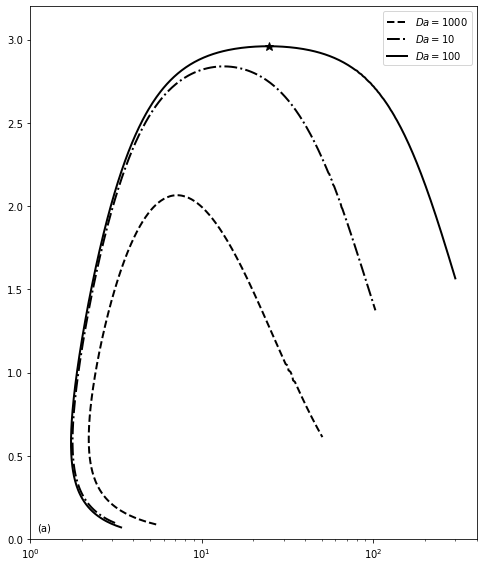

In [9]:
f, ax = plt.subplots()
zoom = 2.0
f.set_size_inches(4.0 * zoom, 4.9 * zoom)
f.set_facecolor('w')

ax.plot(DC_a.k, DC_a.s, '--k', linewidth=2, label=r'$Da=1000$')
ax.plot(DC_b.k, DC_b.s, '-.k', linewidth=2, label=r'$Da=10$')
ax.plot(DC_ref.k, DC_ref.s, '-k', linewidth=2, label=r'$Da=100$')
ax.plot(DC_ref.k[iref], DC_ref.s[iref], '*k', MarkerSize=9)
ax.set_xscale('log')
ax.set_xlim(1.0, 400.0)
ax.set_xticks((1e0, 1e1, 1e2))
ax.set_ylim(0.0, 3.2)
ax.text(1.1, 0.1, '(a)', verticalalignment='top', horizontalalignment='left')
plt.legend()
plt.show()

In [10]:
DC_ref.k[iref], DC_ref.s[iref]

(24.655561068701545, 2.9598758196773103)

In [15]:
k_iref, s_iref = DC_ref.k[iref], DC_ref.s[iref]
SA_ref = reactive_flow_solve_dispersion(k_iref, s_iref, PAR())

lambda_ = 2.0 * np.pi/k_iref
X, Z = np.meshgrid(np.linspace(0.0, 2.0 * lambda_, par.nz), np.linspace(0.0, 1.0, par.nz))
P = np.tile(SA_ref.eig.P, (par.nz, 1)).transpose() * np.exp(1j * k_iref * X)
phi = np.tile(SA_ref.eig.phi, (par.nz, 1)).transpose() * np.exp(1j * k_iref * X)
epsilon = 3e-5
h = 1.0/(par.nz-1.0)
Px, Pz = np.gradient(P, h, h)
F = par.F
U = epsilon * np.real(-np.power(F, 1 - par.n) * par.S * Px)
W = F + epsilon * np.real(F**2 * (par.n-1) * phi - np.power(F, 1 - par.n) * par.S * Pz)
Chi = s_iref * phi - P

P = np.real(P)
P = (P - np.amin(P))/(np.amax(P) - np.amin(P))
phi = np.real(phi)
phi = (phi - np.amin(phi))/(np.amax(phi) - np.amin(phi))
Chi = np.real(Chi)
Chi = (Chi - np.amin(Chi))/(np.amax(Chi) - np.amin(Chi))

SUCCESS: monotonic eigenfunction for k=24.655561068701545, sigma=2.9598758196773103


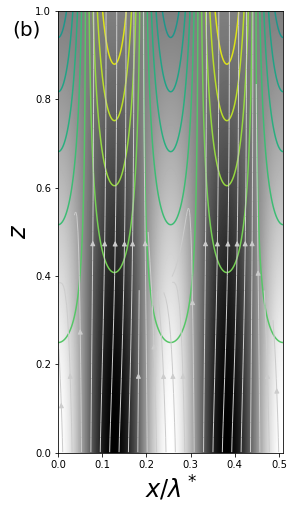

In [19]:
f, ax = plt.subplots()
zoom = 2.0
f.set_size_inches(9.8 * zoom, 4.06 * zoom)
f.set_facecolor('w')

plt.imshow(P, cmap='gray', extent=[0.0, 2.*lambda_, 0.0, 1.0])
cs = plt.contour(X, Z, phi, levels=np.linspace(-1, 1, 20))
# plt.clabel(cs, linewidth=1.5)

nlines = 24
h = 2.0 * lambda_/(nlines+1.0)
seed = np.zeros((nlines, 2))
seed[:, 0] = np.linspace(0.5*h, 2.0*lambda_-0.5*h, nlines)
seed[:, 1] = np.ones_like(seed[:, 0]) / 1000.0
plt.streamplot(X, Z, U, W, start_points=seed, integration_direction='forward', color=[0.8, 0.8, 0.8], linewidth=1)
# set(S,'color',[1 1 1]*0.8,'linewidth',1)
# set(gca,'ytick',[0 0.5 1],'xtick',[0 1 2-eps]*lambda);
# set(gca,'xticklabel',{'0','1','2'});
plt.xlabel(r'$x/\lambda^*$', fontsize=24)
plt.xlim(0, 2.*lambda_)
plt.ylabel(r'$z$', fontsize=24)
plt.ylim(0, 1)
plt.text(-0.04, 0.98, '(b)', fontsize=20, verticalalignment='top', horizontalalignment='right')
plt.show()

### The large-Damkohler number limit


### A modified problem and its analytical solution

## Application to the mantle